In [9]:
import numpy as np, matplotlib.pyplot as plt, glob, os, pandas as pd, \
    simplification.cutil as simpl, matplotlib.colors as mplcol, matplotlib.cm as cm, json
from tqdm import tqdm_notebook as tqdm

In [10]:
# We use an arbitrary recording as illustration
fnamePos = glob.glob('Z:\\behavior\\6-3-19-e\\croprot\\*_dlc_position_orientation.npy')[0]
fnamePos

'Z:\\behavior\\6-3-19-e\\croprot\\e_2019-06-03-111304_dlc_position_orientation.npy'

In [11]:
xyAll = np.load(fnamePos)[:,0:2].astype(np.float32)
xyAll = pd.DataFrame(xyAll).fillna(method='ffill').fillna(method='bfill').values.copy()    

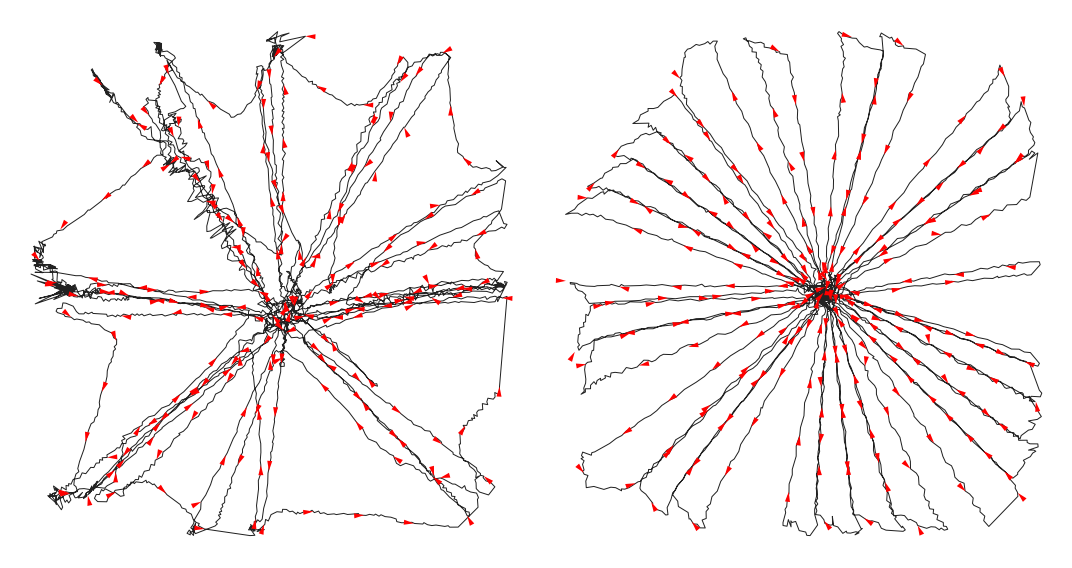

In [101]:
resVW = 10

fig, ax = plt.subplots(1, 2, figsize=(15, 8))

for z, rng in enumerate([[633750, 701729], [701729, 729850]]):
    xy = xyAll[rng[0]:rng[1], :].copy()

    xy = xy[np.linalg.norm(xy - np.array([500, 500]), axis=1) < 580,:]
    segmentIDs = np.cumsum(np.linalg.norm(xy - np.roll(xy, 1, axis=0), axis=1) > 200)

    for sid in np.unique(segmentIDs):
        xyS = xy[segmentIDs==sid, :].copy()

        xySS = simpl.simplify_coords_vw(xyS, resVW)
        ax[z].plot(xySS[:, 0], xySS[:, 1], color='#222222', linewidth=1)

        # Compute directions
        xyDir = xyS - pd.DataFrame(xyS).shift(5).values
        xyDir = xyDir / np.linalg.norm(xyDir, axis=1)[:,np.newaxis]

        # Decide which arrows to plot
        xyDirPlot = np.full(xyDir.shape[0], False, dtype=np.bool)
        lastLoc = None
        for i in range(xyDir.shape[0]):
            if not np.any(np.isnan(xyDir[i,:])):
                if lastLoc is None:
                    lastLoc = xyS[i,:].copy()
                    xyDirPlot[i] = True
                elif np.linalg.norm(lastLoc - xyS[i,:]) >= 100:
                    lastLoc = xyS[i,:].copy()
                    xyDirPlot[i] = True

        # Plot arrows
        for k in np.argwhere(xyDirPlot)[:,0]:
            ax[z].annotate('', xy=(xyS[k,0], xyS[k,1]), 
                        xytext=(xyS[k,0] + xyDir[k,0], xyS[k,1] + xyDir[k,1]),
                arrowprops=dict(headwidth=5, headlength=10, color='red', lw=0), size=20)
    
    ax[z].set_axis_off()
    
fig.tight_layout()
fig.savefig('C:/Users/acorver/Desktop/paper-figures/Fig_Suppl_5.pdf', dpi=250)